In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from math import sqrt, pi,exp,log2
from random import random
from hilbertcurve.hilbertcurve import HilbertCurve

In [43]:
def Im2chaine(image):
    mat=np.asarray(image,)
    n=len(mat)
    chaine=np.zeros(n*n,dtype='int64')
    hilbert_curve=HilbertCurve(int(log2(n)),2)
    for i in range(n):
        for j in range(n):
            chaine[hilbert_curve.distance_from_coordinates([i,j])]=mat[i][j]
    return chaine
def chaine2Im(chaine):
    n=len(chaine)
    m=int(sqrt(n))
    mat=np.zeros((m,m))
    hilbert_curve=HilbertCurve(int(log2(n)),2)
    for i in range(n):
        coor=hilbert_curve.coordinates_from_distance(i)
        mat[coor[0]][coor[1]]=chaine[i]
    return (mat)
def lit_image(nom_image):
    im=Image.open(nom_image)
    return (np.array(im),im.size[0],im.size[1])
def affiche_image(mat_image,titre,show=True):
    plt.title(titre)
    plt.imshow(mat_image,cmap='Greys_r')
    if show:
        plt.show()
def identif_classes(X):
    hist=np.histogram(X.flatten(),bins=2)
    return(hist[1][0],hist[1][2])
def bruit_gauss(X,m,n,cl1,cl2,m1,sig1,m2,sig2):
    gauss_1=np.random.normal(m1,sig1,(m,n))
    gauss_2=np.random.normal(m2,sig2,(m,n))
    return(np.where(X==cl1,gauss_1,gauss_2))
def norm_pdf(Y,mu,sig):
    return(np.exp((-(Y-mu)**2)/(2*sig**2))/(sqrt(2*pi)*sig))
def taux_erreur(A,B):
    moy=np.mean(np.abs(A-B)/255)
    return(min(moy,1-moy))

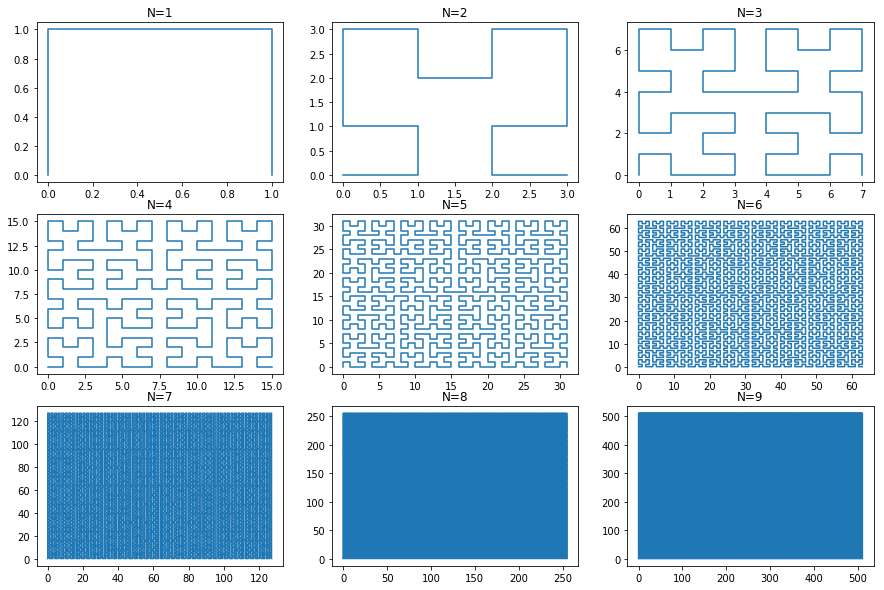

In [22]:
fig=plt.figure(figsize=(15,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    N=2**(i)
    hilbert_curve=HilbertCurve(int(log2(N)),2)
    coords=np.zeros((N**2,2))
    for j in range(N**2):
        coords[j]=hilbert_curve.coordinates_from_distance(j)
    plt.title("N="+str(i))
    plt.plot(coords[:,0],coords[:,1])

In [44]:

def calc_transit_prio2(X,n,cl1,cl2):
    A=np.zeros((2,2))
    countcl1=0
    countcl2=0
    for i in range(1,n):
        if X[i-1]==cl1 and X[i]==cl1:
            A[0][0]+=1
            countcl1+=1
        elif X[i-1]==cl1 and X[i]==cl2:
            A[0][1]+=1
            countcl1+=1
        elif X[i-1]==cl2 and X[i]==cl1:
            A[1][0]+=1
            countcl2+=1
        elif X[i-1]==cl2 and X[i]==cl2:
            A[1][1]+=1
            countcl2+=1
        else:
            print('Character undifined')
    A=np.array([A[0]/countcl1,A[1]/countcl2])
    return(A)
def Mat_f_gauss2(Y,m1,sig1,m2,sig2):
    return np.array([norm_pdf(Y,m1,sig1).T,norm_pdf(Y,m2,sig2).T])
def forward2_CMC(Mat_f,n,A,p10,p20):
    alpha=np.zeros((2,n))
    alpha[0][0]=p10*Mat_f[0][0]
    alpha[1][0]=p20*Mat_f[1][0]
    s=alpha[0][0]+alpha[1][0]
    alpha[:,0]=alpha[:,0]/s
    for i in range(1,n):
        alpha[0][i]=Mat_f[0][i]*np.transpose(alpha[:,i-1])@A[:,0]
        alpha[1][i]=Mat_f[1][i]*np.transpose(alpha[:,i-1])@A[:,1]
        s=alpha[0][i]+alpha[1][i]
        alpha[:,i]=alpha[:,i]/s
    return alpha
def backward2_CMC(Mat_f,n,A):
    beta=np.zeros((2,n))
    beta[0][0]=1
    beta[1][0]=1
    s=beta[0][0]+beta[1][0]
    beta[:,0]=beta[:,0]/s
    for i in range(1,n):
        beta[0][i]=Mat_f[0][i]*np.transpose(beta[:,i-1])@A[:,0]
        beta[1][i]=Mat_f[1][i]*np.transpose(beta[:,i-1])@A[:,1]
        s=beta[0][i]+beta[1][i]
        beta[:,i]=beta[:,i]/s
    return beta
def MPM_chaines2_CMC(Y,Mat_f,n,cl1,cl2,A,p10,p20):
    alpha=forward2_rescale(Mat_f,n,A,p10,p20)
    beta=backward2_rescale(Mat_f,n,A)
    X_apost=np.zeros(n)
    for i in range(n):
        if(alpha[0][i]*beta[0][i]>alpha[1][i]*beta[1][i]):
            X_apost[i]=cl1
        else:
            X_apost[i]=cl2
    return X_apost

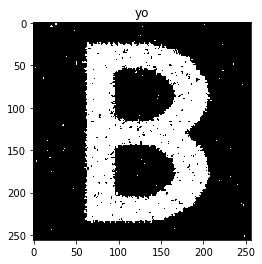

In [42]:
image,m,n=lit_image('./images/beee2.bmp')
image_chaine=Im2chaine(image)
image_bruite=bruit_gauss(image_chaine,1,n*n,0,255,1,1,2,3)
A=calc_transit_prio2(image_chaine,n*n,0,255)
Mat_f=Mat_f_gauss2(image_bruite,1,1,2,3)
image_segmente=MPM_chaines2_rescale(image_bruite,Mat_f,n*n,0,255,A,0.5,0.5)
affiche_image(chaine2Im(image_segmente),'segmentation CMC MPM')